In [2]:
!pip install monai
!pip install nibabel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 28.6 MB/s eta 0:00:00a 0:00:01


In [3]:
import glob
import os
import torch
import numpy as np
import pandas as pd
import nibabel as nib
import skimage.measure
import skimage.morphology

from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd,
    NormalizeIntensityd, EnsureTyped, Invertd, Activationsd, AsDiscreted
)
from monai.data import Dataset, DataLoader, decollate_batch
from monai.networks.nets import SegResNet

# ==========================================
# 1. SETUP & PATHS
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Update this path if necessary
test_dir = "/kaggle/input/instant-odc-ai-hackathon/test" 
model_path = "/kaggle/input/2d-patient/best_metric_model_2d (4).pth"

test_folders = sorted(glob.glob(os.path.join(test_dir, "*")))
test_files = []

for t in test_folders:
    # Skip non-directories (like .ipynb files)
    if not os.path.isdir(t):
        continue
        
    p_id = os.path.basename(t) # e.g., BraTS2021_01333
    
    # Construct paths
    flair = os.path.join(t, f"{p_id}_flair.nii")
    t1 = os.path.join(t, f"{p_id}_t1.nii")
    t1ce = os.path.join(t, f"{p_id}_t1ce.nii")
    t2 = os.path.join(t, f"{p_id}_t2.nii")
    
    # Check existence
    if not os.path.exists(flair):
        # Fallback for .nii.gz
        if os.path.exists(flair + ".gz"):
            flair += ".gz"
            t1 += ".gz"
            t1ce += ".gz"
            t2 += ".gz"
    
    test_files.append({
        "image": [flair, t1, t1ce, t2],
        "id": p_id
    })

print(f"Found {len(test_files)} valid patient folders.")

# ==========================================
# 2. TRANSFORMS
# ==========================================
test_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    EnsureTyped(keys=["image"]),
])

# INVERTD: Reverses transforms to match original geometry
post_transforms = Compose([
    Invertd(
        keys="pred",
        transform=test_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    Activationsd(keys="pred", sigmoid=True),
    AsDiscreted(keys="pred", threshold=0.5),
])

# ==========================================
# 3. HELPER FUNCTIONS (RLE & CLEANING)
# ==========================================
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    if len(dots) == 0: 
        return ""
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))

def clean_mask(mask, min_size=100):
    """
    Removes small disconnected speckles (noise) from the prediction.
    """
    # 1. Label connected regions
    labeled_mask, num_features = skimage.measure.label(mask, connectivity=2, return_num=True)
    
    # 2. If empty, return
    if num_features == 0:
        return mask

    # 3. Remove small objects
    cleaned = skimage.morphology.remove_small_objects(labeled_mask.astype(bool), min_size=min_size)
    
    return cleaned.astype(np.uint8)

# ==========================================
# 4. LOAD MODEL
# ==========================================
model = SegResNet(
    spatial_dims=2, 
    init_filters=32, 
    in_channels=4, 
    out_channels=3, 
    dropout_prob=0.2
).to(device)

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("Model weights loaded.")
else:
    print(f"⚠️ Warning: Model file '{model_path}' not found.")

model.eval()

# ==========================================
# 5. INFERENCE LOOP
# ==========================================
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

submission_rows = []

print("Starting Inference...")

with torch.no_grad():
    for batch_data in test_loader:
        patient_id = batch_data["id"][0]
        
        # Get image (1, 4, H, W, D)
        images = batch_data["image"].to(device)
        
        # --- 3D to 2D Conversion ---
        vol = images[0] 
        vol_slices = vol.permute(3, 0, 1, 2) 
        
        # Run model
        preds_slices = model(vol_slices) # (D, 3, H, W)
        
        # --- 2D to 3D Reconstruction ---
        preds_vol = preds_slices.permute(1, 2, 3, 0).unsqueeze(0)
        
        # Assign for inversion
        batch_data["pred"] = preds_vol
        
        # --- Inverse Transform ---
        # This fixes the orientation/spacing to match the competition file
        batch_data = [post_transforms(i) for i in decollate_batch(batch_data)]
        final_pred = batch_data[0]["pred"]
        
        # --- Separate Labels ---
        # Model Output: 0=TC, 1=WT, 2=ET
        tc = final_pred[0]
        wt = final_pred[1]
        et = final_pred[2]
        
        # Calculate Competition Labels
        label_4 = et
        label_2 = wt - tc
        label_1 = tc - et
        
        # Fix negatives
        label_2[label_2 < 0] = 0
        label_1[label_1 < 0] = 0
        
        # Convert to CPU numpy
        l1 = label_1.cpu().numpy().astype(np.uint8)
        l2 = label_2.cpu().numpy().astype(np.uint8)
        l4 = label_4.cpu().numpy().astype(np.uint8)
        
        # --- POST PROCESSING (Cleaning) ---
        # We remove small noise objects. 
        # Enhancing tumor (l4) is often smaller, so we use a smaller threshold (50)
        # Edema (l2) and Necrotic (l1) are usually larger, so threshold 100
        l1 = clean_mask(l1, min_size=100)
        l2 = clean_mask(l2, min_size=100)
        l4 = clean_mask(l4, min_size=50)

        # --- RLE Encoding ---
        submission_rows.append([f"{patient_id}_1", rle_encoding(l1)])
        submission_rows.append([f"{patient_id}_2", rle_encoding(l2)])
        submission_rows.append([f"{patient_id}_4", rle_encoding(l4)])
        
        print(f"Processed {patient_id}")

# ==========================================
# 6. SAVE
# ==========================================
df = pd.DataFrame(submission_rows, columns=['id', 'rle'])
df.to_csv("submission.csv", index=False)
print("submission.csv generated successfully!")

Found 334 valid patient folders.
Model weights loaded.
Starting Inference...
Processed BraTS2021_01333
Processed BraTS2021_01334
Processed BraTS2021_01335
Processed BraTS2021_01336
Processed BraTS2021_01337
Processed BraTS2021_01338
Processed BraTS2021_01339
Processed BraTS2021_01340
Processed BraTS2021_01341
Processed BraTS2021_01342
Processed BraTS2021_01343
Processed BraTS2021_01344
Processed BraTS2021_01345
Processed BraTS2021_01346
Processed BraTS2021_01347
Processed BraTS2021_01348
Processed BraTS2021_01349
Processed BraTS2021_01350
Processed BraTS2021_01351
Processed BraTS2021_01352
Processed BraTS2021_01353
Processed BraTS2021_01354
Processed BraTS2021_01355
Processed BraTS2021_01356
Processed BraTS2021_01357
Processed BraTS2021_01358
Processed BraTS2021_01359
Processed BraTS2021_01360
Processed BraTS2021_01361
Processed BraTS2021_01362
Processed BraTS2021_01363
Processed BraTS2021_01364
Processed BraTS2021_01365
Processed BraTS2021_01366
Processed BraTS2021_01367
Processed Bra

Checking Alignment on: BraTS2021_01500_flair.nii
Running Model...
✅ Tumor found! Inspecting Slice 63


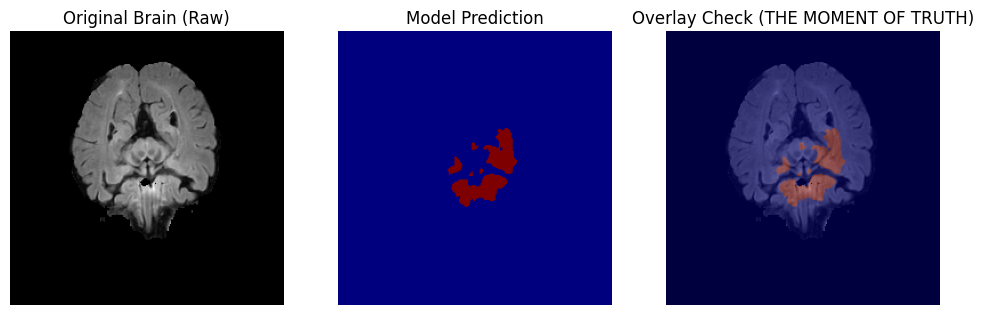

In [12]:
# ==========================================
# FIXED BLIND ALIGNMENT CHECK (Visual Only)
# ==========================================
import os
import glob
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torch
from monai.networks.nets import SegResNet

# --- CONFIGURATION ---
test_dir = "/kaggle/input/instant-odc-ai-hackathon/test"
model_path = "/kaggle/input/2d-patient/best_metric_model_2d (4).pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. FIND A TEST PATIENT ---
test_images_flair = sorted(glob.glob(os.path.join(test_dir, "**", "*_flair.nii"), recursive=True))
if not test_images_flair:
    test_images_flair = sorted(glob.glob(os.path.join(test_dir, "**", "*_flair.nii.gz"), recursive=True))

# Pick a patient in the middle
target_path = test_images_flair[len(test_images_flair)//2]
print(f"Checking Alignment on: {os.path.basename(target_path)}")

# --- 2. LOAD RAW DATA ---
flair = nib.load(target_path).get_fdata()

root = os.path.dirname(target_path)
p_id = "_".join(os.path.basename(target_path).split("_")[:-1])
ext = ".nii.gz" if target_path.endswith(".nii.gz") else ".nii"
t1 = nib.load(os.path.join(root, f"{p_id}_t1{ext}")).get_fdata()
t1ce = nib.load(os.path.join(root, f"{p_id}_t1ce{ext}")).get_fdata()
t2 = nib.load(os.path.join(root, f"{p_id}_t2{ext}")).get_fdata()

vol = np.stack([flair, t1, t1ce, t2], axis=0)

# --- 3. NORMALIZE (Contrast Fix) ---
for ch in range(4):
    mask = vol[ch] > 0
    if mask.any():
        mean = vol[ch][mask].mean()
        std = vol[ch][mask].std()
        vol[ch] = (vol[ch] - mean) / (std + 1e-8)
        vol[ch][~mask] = 0

# --- 4. PREDICT ---
print("Running Model...")
model = SegResNet(spatial_dims=2, init_filters=32, in_channels=4, out_channels=3, dropout_prob=0.2).to(device)
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    raise FileNotFoundError("Model not found!")
model.eval()

vol_tensor = torch.from_numpy(vol).float().to(device).unsqueeze(0)
depth = vol_tensor.shape[-1]
preds = []

with torch.no_grad():
    for d in range(depth):
        slice_in = vol_tensor[..., d]
        out = model(slice_in)
        preds.append((out.sigmoid() > 0.5).float().cpu().numpy())

# FIX: Use stack instead of concatenate to preserve depth dimension
pred_3d = np.stack(preds, axis=-1)[0] # Shape: (3, H, W, D)

# --- 5. VISUALIZE ---
# Channel 1 = Whole Tumor
tumor_area = np.sum(pred_3d[1], axis=(0,1)) 
slice_idx = np.argmax(tumor_area)

if np.max(tumor_area) == 0:
    print("⚠️ Model found NO tumor. Showing middle slice.")
    slice_idx = depth // 2
else:
    print(f"✅ Tumor found! Inspecting Slice {slice_idx}")

plt.figure(figsize=(12, 5))

# Original FLAIR
plt.subplot(1, 3, 1)
plt.title("Original Brain (Raw)")
plt.imshow(flair[:, :, slice_idx].T, cmap="gray", origin="lower")
plt.axis("off")

# Prediction
plt.subplot(1, 3, 2)
plt.title("Model Prediction")
plt.imshow(pred_3d[1, :, :, slice_idx].T, cmap="jet", origin="lower")
plt.axis("off")

# Overlay
plt.subplot(1, 3, 3)
plt.title("Overlay Check (THE MOMENT OF TRUTH)")
plt.imshow(flair[:, :, slice_idx].T, cmap="gray", origin="lower")
plt.imshow(pred_3d[1, :, :, slice_idx].T, cmap="jet", alpha=0.5, origin="lower")
plt.axis("off")

plt.show()